In [1]:
# Read RData

from __future__ import unicode_literals

import json
from os import listdir, getcwd
from os.path import isfile, join
import rpy2.robjects as ro

mypath = getcwd()+"/data/tweet_youtube"
onlyfiles = [ join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
tweets_time = {}
for f in onlyfiles:
    ro.r['load'](f,ro.globalenv)
    print(ro.r.ls(ro.globalenv))
    break

[1] "data"



In [2]:
# Prepare data for our model

from rpy2.robjects import numpy2ri
import numpy as np
shares = ro.globalenv[str('data')].rx2("numShare")
views = ro.globalenv[str('data')].rx2("dailyViewcount")

In [19]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import numpy as np
import tensorflow as tf

# Define a model

seed = 42
tf.set_random_seed(seed)

def simple_NN(embeddings_for_views,embed_s,embed_v,hidden_size, nclass):
    
    shape_1 = embed_s.get_shape().as_list()
    shape_2 = embed_v.get_shape().as_list()
    
    with tf.variable_scope('Layer_1') as scope:
        try:
            W_1 = tf.get_variable('W_1', [hidden_size,shape_1[1]+shape_2[1]],
            initializer=tf.random_normal_initializer(stddev=0.5))
        except ValueError:
            scope.reuse_variables()
            W_1 = tf.get_variable('W_1')
        
        h_1 = tf.nn.sigmoid(tf.matmul(W_1, tf.concat(1,[embed_s, embed_v]), transpose_b=True))
    
    with tf.variable_scope('Softmax') as scope2:
        # dim of scores: vocabulary_size*batch_size
        try:
            W_softmax = tf.get_variable('W_softmax', [nclass,hidden_size],
            initializer=tf.random_normal_initializer(stddev=0.5))
        except ValueError:
            scope2.reuse_variables()
            W_softmax = tf.get_variable('W_softmax')
        scores = tf.matmul(W_softmax, h_1)
    
    return tf.transpose(scores)

def map_shares_or_views(share_value, max_value):
    new_value = int(share_value/max_value*100)
    if(new_value>100):
        new_value = 100
    return(new_value)

# embeddinds for continous variables
size_for_shares = 101
dim_for_embeddings_for_shares = 100
embeddings_for_shares = tf.Variable(tf.random_uniform([size_for_shares, dim_for_embeddings_for_shares], -0.5, 0.5))

size_for_views = 101
dim_for_embeddings_for_views = 100
embeddings_for_views = tf.Variable(tf.random_uniform([size_for_views, dim_for_embeddings_for_views], -0.5, 0.5))

# placeholders
s = tf.placeholder(tf.int64, shape=[None])
v = tf.placeholder(tf.int64, shape=[None])
y = tf.placeholder(tf.int64, shape=[None])

embed_s = tf.nn.embedding_lookup(embeddings_for_shares, s)
embed_v = tf.nn.embedding_lookup(embeddings_for_views, v)

# predict
res = simple_NN(embeddings_for_views,embed_s,embed_v, 110, size_for_views)
#correct_prediction = tf.equal(res, y)
#cost = tf.reduce_mean(correct_prediction)
#res = tf.cast(res,tf.float64)
#mse = tf.reduce_mean(tf.cast(tf.squared_difference(res,y),tf.float64))

y_one_hot = tf.one_hot(y,depth = size_for_views)
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=res))

op = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(cross_entropy)

In [20]:
# 75 for training, 15 for validation and 30 for testing
def split_data(data):
    L = len(data)
    train = [ data[i] for i in range(L-120,L-30)]
    #validation = [ data[i] for i in range(L-45,L-30)]
    test = [ data[i] for i in range(L-30,L)]
    return train,test

# All values maped to [0,100]
def process_data(data):
    upper_bound = np.amax(data[-120:-30])
    return [ map_shares_or_views(i,upper_bound) for i in data]

# Prepare data set for our model
# tuple(tuple(s,v),y)
def generate_set(s,v):
    s = process_data(s)
    v = process_data(v)
    
    train_s, test_s = split_data(s)
    train_v, test_v = split_data(v)
    
    train_x_s = train_s[:-1]
    train_x_v = train_v[:-1]
    train_x = (train_x_s,train_x_v)
    train_y = train_v[1:]
    train = (train_x,train_y)
    
    test_x_s = np.append(train_s[-1],test_s[:-1])
    test_x_v = np.append(train_v[-1],test_v[:-1])
    test_x = (test_x_s,test_x_v)
    test_y = test_v
    test = (test_x,test_y)
    
    return train, test

In [23]:
num_steps = 20000 

results = {}

index = 998
s_i = np.array(shares[index])
v_i = np.array(views[index])
train, test = generate_set(s_i,v_i)
e = np.amax(v_i[-120:-30])
session = tf.Session()

# Training
init = tf.global_variables_initializer()
session.run(init)

for step in range(num_steps):

    _,loss = session.run([op,cross_entropy],feed_dict={s: train[0][0], v: train[0][1], y : train[1]})

    if step%2000 == 0:
        print(loss)

print("Done! (training)")

# Test
current_s = [test[0][0][0]]
predict = []
for step in range(len(test[1])):
    output = session.run(res,feed_dict={s: current_s, v: [test[0][1][step]]})
    current_s = tf.argmax(output,1)
    with tf.Session() as sess:
        current_s = current_s.eval()
        predict.append((current_s[0]+0.5)/100*e)
print("Done! (testing)")

results[index] = predict

8.45422
0.319464
0.318414
0.31807
0.3179
0.317799
0.317732
0.317684
0.317649
0.317621
Done! (training)
Done! (testing)


In [ ]:
# # Parallel

# def loop_func(index,shares,views):
#     num_steps = 20000 
    
#     s_i = np.array(shares[index])
#     v_i = np.array(views[index])
#     train, test = generate_set(s_i,v_i)
#     e = np.amax(v_i[-120:-30])
#     session = tf.Session()

#     # Training
#     init = tf.global_variables_initializer()
#     session.run(init)

#     for step in range(num_steps):

#         _,loss = session.run([op,cross_entropy],feed_dict={s: train[0][0], v: train[0][1], y : train[1]})

#         if step%2000 == 0:
#             print(loss)

#     print("Done! (training)")
    
#     # Test
#     current_s = [test[0][0][0]]
#     predict = []
#     for step in range(len(test[1])):
#         output = session.run(res,feed_dict={s: current_s, v: [test[0][1][step]]})
#         current_s = tf.argmax(output,1)
#         with tf.Session() as sess:
#             current_s = current_s.eval()
#             predict.append((current_s[0]+0.5)/100*e)
#     print("Done")
#     return predict

# results = {}
# from multiprocessing import Pool
# pool = Pool()
# result1 = pool.apply_async(loop_func, [0,shares,views])   
# result2 = pool.apply_async(loop_func, [1,shares,views]) 
# answer1 = result1.get()
# answer2 = result2.get()
# results[0] = answer1
# results[1] = answer2

Process PoolWorker-4:
Process PoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    task = get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/usr/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    racquire()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
KeyboardInterrupt
    return recv()
KeyboardInterrupt


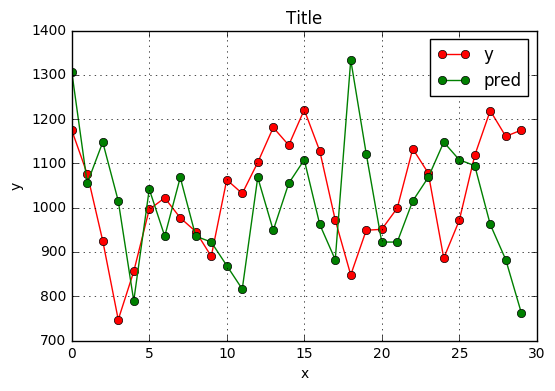

In [24]:
import matplotlib.pyplot as plt 

plt.title("Title")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(range(len(v_i[-30:])),v_i[-30:],'o-',color = 'r',label = "y")
plt.plot(range(len(predict)),predict,'o-',color = 'g', label = "pred")
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

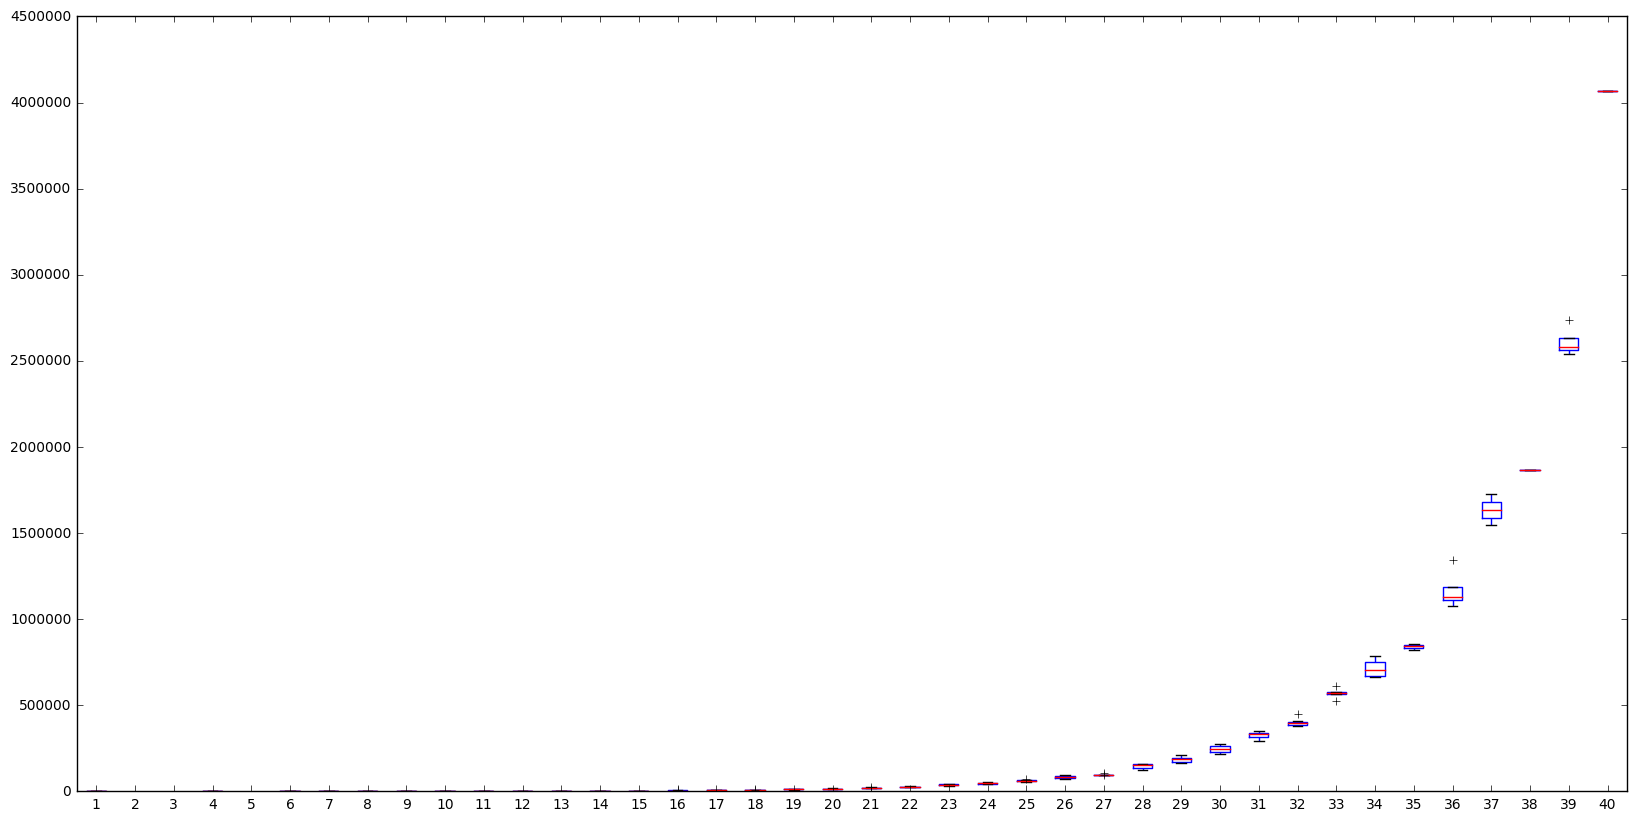